In [1]:
### total flow plots ###
### DTT, 10/22

# This script is split into two main parts: 1) reading in CONUS2 gridded total (aggregated) daily flow for the full domain and creating a dataframe of CONUS2 flow for cells that have been matched with USGS gages in the `NWM_Gage_Adjustments_final.csv`. 2) matching the gages that both have flow between the PF csv and USGS csv retrieved from hydrodata. 
# Note that flow is converted in this script from daily accumulated flow in [m^3/h] to daily mean flow in cms or [m^3/s].

### Inputs:
# - `NWM_Gage_Adjustments_final.csv` - this can be found on the CONUS2 Dropbox or in /glade/p/univ/ucsm0002/CONUS2/domain_files
# - Daily total streamflow PFCLM outputs as PFBs - processed using `compute_daily_PF_averages.py`
# - USGS daily flow csv - from the hydrodata repository on Verde

### Outputs:
# - CSV of PFCLM daily mean flow (cms) with gage ID, lat/long, and CONUS2 cell location
# - two flow-matched CSVs for PF and USGS flow
# - note that the CSV outputs with 'day 001' which starts at the water year (001 == October 1)***

# Notes:
# - need to fix the no_days, currently this will only be accurate if this is started at the begninning of a water year and need to add in some dictionary or if statement to specify num days in a month or something like that.
# - ***need to change day headings so that they are more descriptive than 'day 001' and have an actual date

import sys
from parflow.tools.io import read_pfb,write_pfb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# need to change water year and number of days
water_year = 2003
no_days = 31 

# Directory where PF flow PFBs are saved in
directory_out = '/hydrodata/temp/CONUS2_transfers/CONUS2_spinup_WY2003/averages'#'/glade/scratch/tijerina/CONUS2/spinup_WY2003/averages'
organized_dir =  './Organized_Daily_Flow'#'/glade/p/univ/ucsm0002/CONUS2/Validation/Streamflow/Organized_Daily_Flow'
plot_dir = './Figures'#'/glade/p/univ/ucsm0002/CONUS2/Validation/Streamflow/Figures'

# names of csv files
usgs_csv = 'FlowMatch_USGS_daily_cms_2003.csv'
pf_csv = 'FlowMatch_CONUS2_daily_cms_2003.csv'
metadata_csv = 'FlowMatch_metadata_2003.csv'




# Average Flow Comparison
Right now, this is just monthly (Oct WY2003), but eventually it should be annual average flow comparison 

In [2]:
usgs_daily_flow = pd.read_csv(f'{organized_dir}/{usgs_csv}',index_col=['site_id'])
CONUS2_daily_flow = pd.read_csv(f'{organized_dir}/{pf_csv}',index_col=['site_id'])
CONUS2_daily_flow = CONUS2_daily_flow.drop(columns=['USGS_lat', 'USGS_lon', 'x_new_adj', 'y_new_adj'])
metadata_df = pd.read_csv(f'{organized_dir}/{metadata_csv}',index_col=['site_id'])

usgs_daily_flow.head()

,2002-10-01,2002-10-02,2002-10-03,2002-10-04,2002-10-05,2002-10-06,2002-10-07,2002-10-08,2002-10-09,2002-10-10,...,2002-10-22,2002-10-23,2002-10-24,2002-10-25,2002-10-26,2002-10-27,2002-10-28,2002-10-29,2002-10-30,2002-10-31
site_id,,,,,,,,,,,,,,,,,,,,,
1011000,7.414600,7.386300,6.990100,6.565600,6.36750,6.19770,5.744900,5.065700,4.528000,4.414800,...,9.310700,8.57490,8.546600,8.631500,9.820100,12.508600,15.508400,16.52720,15.791400,14.319800
1013500,3.509200,3.424300,3.169600,3.113000,3.33940,2.85830,2.858300,2.631900,2.405500,2.504550,...,5.263800,5.40530,5.660000,5.914700,6.197700,6.990100,7.556100,7.30140,7.188200,7.273100
1015800,6.707100,6.226000,5.716600,5.377000,5.15060,5.03740,4.754400,4.499700,4.160100,4.188400,...,22.300400,19.07420,16.725300,14.914100,13.725500,12.904800,12.848200,13.72550,13.725500,13.074600
1017000,9.876700,9.367300,8.461700,7.952300,7.81080,7.13160,7.046700,6.678800,6.282600,6.282600,...,38.205000,33.39400,28.583000,24.507800,21.762700,20.376000,20.715600,21.79100,21.734400,20.347700
1017550,0.023772,0.024338,0.020659,0.018395,0.01981,0.01981,0.018678,0.018678,0.018961,0.021791,...,0.044997,0.03679,0.036224,0.035092,0.030847,0.041884,0.051789,0.03962,0.031979,0.027451


In [3]:
CONUS2_daily_flow.head()

,day 001,day 002,day 003,day 004,day 005,day 006,day 007,day 008,day 009,day 010,...,day 022,day 023,day 024,day 025,day 026,day 027,day 028,day 029,day 030,day 031
site_id,,,,,,,,,,,,,,,,,,,,,
1011000,4.339120,3.903565,3.598231,3.739801,3.472192,2.964904,2.711756,2.519148,2.262331,2.004412,...,8.415931,9.427277,9.732380,19.499970,22.328073,21.454524,17.873519,15.879472,14.244763,12.567175
1013500,2.607411,2.592114,2.714427,2.122667,2.426324,1.780095,1.482548,1.307613,1.202425,1.285236,...,10.531182,10.841114,10.288957,10.600749,12.061306,16.507953,16.798331,14.819481,13.234019,11.639035
1015800,3.538157,3.513982,3.389648,3.025167,2.979538,2.794375,2.514015,2.242985,2.058773,2.187055,...,23.623506,33.084342,38.403587,35.184230,30.383635,27.200526,22.780802,20.339741,18.833875,17.107330
1017000,8.474701,8.578840,8.433320,8.120163,7.786723,7.233890,6.638142,6.070441,5.608575,5.285559,...,17.952113,33.277058,46.507889,49.141900,53.410219,58.835318,57.151723,53.937779,50.008866,44.393264
1017550,0.000110,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.126239,0.077560,0.050756,0.034315,0.048476,0.110372,0.062056,0.042434,0.028833,0.021246


In [4]:
metadata_df.columns

Index(['site_type', 'agency', 'site_name', 'site_id_agency', 'site_query_url',
       'site_query_access_date', 'latitude', 'longitude', 'state', 'huc',
       'tz_cd', 'observation_id', 'site_id:1', 'var_id', 'start_date_listed',
       'end_date_listed', 'is_current', 'is_series',
       'first_date_data_available', 'last_date_data_available', 'record_count',
       'date_verified_through', 'latest_download_date', 'file_path',
       'conus1_x', 'conus1_y', 'conus1_latitude', 'conus1_longitude',
       'conus1_moved', 'conus1_parflow_drainage_area', 'conus2_x', 'conus2_y',
       'conus2_latitude', 'conus2_longitude', 'conus2_moved',
       'conus2_parflow_drainage_area', 'gages_drainage_sqkm', 'bound_source',
       'class', 'aggecoregion', 'hydro_disturb_indx', 'wr_report_remarks',
       'adr_citation', 'screening_comments', 'basin_compactness',
       'basin_elevation_mean_meters', 'basin_elevation_max_meters',
       'basin_elevation_min_meters', 'basin_elevation_median_meters',

In [5]:
metadata_df

,site_type,agency,site_name,site_id_agency,site_query_url,site_query_access_date,latitude,longitude,state,huc,...,basin_cd,topo_cd,instruments_cd,construction_dt,inventory_dt,drain_area_va,contrib_drain_area_va,local_time_fg,reliability_cd,project_no
site_id,,,,,,,,,,,,,,,,,,,,,
1011000,stream gauge,USGS,"Allagash River near Allagash, Maine",1011000,https://waterservices.usgs.gov/nwis/site/?form...,2022-08-30,47.069722,-69.079444,ME,1010002,...,NaN,NaN,YNNNYNNNNYNNNNNNYNNNNNNNNNNNNN,NaN,NaN,1478.00,1229.00,Y,NaN,442300100.0
1013500,stream gauge,USGS,"Fish River near Fort Kent, Maine",1013500,https://waterservices.usgs.gov/nwis/site/?form...,2022-08-30,47.237500,-68.582778,ME,1010003,...,NaN,NaN,YNNNYNYNNYNNNNNNYNNNNNNNNNNNNN,NaN,NaN,873.00,873.00,Y,NaN,442300100.0
1015800,stream gauge,USGS,"Aroostook River near Masardis, Maine",1015800,https://waterservices.usgs.gov/nwis/site/?form...,2022-08-30,46.523056,-68.371667,ME,1010004,...,NaN,NaN,YNNNYNYNNYNNNNNNYNNNNNNNNNNNNN,NaN,NaN,892.00,892.00,Y,NaN,442300100.0
1017000,stream gauge,USGS,"Aroostook River at Washburn, Maine",1017000,https://waterservices.usgs.gov/nwis/site/?form...,2022-08-30,46.777222,-68.157222,ME,1010004,...,NaN,NaN,YNNNYNYNNYNNNNNNYNNNNNNNNNNNNN,NaN,NaN,1654.00,1654.00,Y,NaN,442300100.0
1017550,stream gauge,USGS,"Williams Brook at Phair, Maine",1017550,https://waterservices.usgs.gov/nwis/site/?form...,2022-08-30,46.628056,-67.953056,ME,1010005,...,NaN,NaN,YNNNYNYNNYNNNNNNYNNNNNNNNNNNNN,NaN,NaN,3.82,3.82,Y,NaN,442300100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214657975,stream gauge,USGS,"IRVINS CREEK AT SR3168 NR CHARLOTTE, NC",214657975,https://waterservices.usgs.gov/nwis/site/?form...,2022-08-30,35.158611,-80.713333,NC,3050103,...,10.0,NaN,YNNYNNNNNNNNNNNNNNNNNNNNNNNNNN,NaN,NaN,8.37,NaN,Y,NaN,453700100
242354750,stream gauge,USGS,"CAHABA VALLEY CREEK AT CROSS CR RD AT PELHAM, AL.",242354750,https://waterservices.usgs.gov/nwis/site/?form...,2022-08-30,33.313445,-86.806377,AL,3150202,...,NaN,NaN,NNNNYNNNNNNNNNNNNNNNNNNNNNNNNN,NaN,NaN,25.60,25.60,Y,NaN,NaN
344894205,stream gauge,USGS,"NORTH FORK SWANNANOA RIVER NEAR WALKERTOWN, NC",344894205,https://waterservices.usgs.gov/nwis/site/?form...,2022-08-30,35.685278,-82.332778,NC,6010105,...,12.0,NaN,NNNNYNNNNNNNNNNNNNNNNNNNNNNNNN,NaN,19890130.0,14.50,NaN,Y,NaN,453700100


### Calculate mean flows

In [6]:
usgs_daily_flow['usgs total flow'] = usgs_daily_flow.sum(axis=1)
usgs_daily_flow['daily mean'] = usgs_daily_flow.sum(axis=1)/no_days
#usgs_daily_flow['monthly total (log)'] = np.log10(usgs_daily_flow.sum(axis=1)) # DONT HAVE TO DO THIS HERE BECAUSE YOU CAN SET THE PLOT AXIS
# #usgs_daily_flow['daily mean log'] = np.log10(usgs_daily_flow['daily mean'])

In [7]:
usgs_daily_flow.head()

,2002-10-01,2002-10-02,2002-10-03,2002-10-04,2002-10-05,2002-10-06,2002-10-07,2002-10-08,2002-10-09,2002-10-10,...,2002-10-24,2002-10-25,2002-10-26,2002-10-27,2002-10-28,2002-10-29,2002-10-30,2002-10-31,usgs total flow,daily mean
site_id,,,,,,,,,,,,,,,,,,,,,
1011000,7.414600,7.386300,6.990100,6.565600,6.36750,6.19770,5.744900,5.065700,4.528000,4.414800,...,8.546600,8.631500,9.820100,12.508600,15.508400,16.52720,15.791400,14.319800,239.729300,15.466406
1013500,3.509200,3.424300,3.169600,3.113000,3.33940,2.85830,2.858300,2.631900,2.405500,2.504550,...,5.660000,5.914700,6.197700,6.990100,7.556100,7.30140,7.188200,7.273100,133.157160,8.590785
1015800,6.707100,6.226000,5.716600,5.377000,5.15060,5.03740,4.754400,4.499700,4.160100,4.188400,...,16.725300,14.914100,13.725500,12.904800,12.848200,13.72550,13.725500,13.074600,299.102700,19.296948
1017000,9.876700,9.367300,8.461700,7.952300,7.81080,7.13160,7.046700,6.678800,6.282600,6.282600,...,28.583000,24.507800,21.762700,20.376000,20.715600,21.79100,21.734400,20.347700,480.534000,31.002194
1017550,0.023772,0.024338,0.020659,0.018395,0.01981,0.01981,0.018678,0.018678,0.018961,0.021791,...,0.036224,0.035092,0.030847,0.041884,0.051789,0.03962,0.031979,0.027451,1.117567,0.072101


In [8]:
CONUS2_daily_flow['pf total flow'] = CONUS2_daily_flow.sum(axis=1)
CONUS2_daily_flow['daily mean'] = CONUS2_daily_flow.sum(axis=1)/no_days
#CONUS2_daily_flow['monthly total (log)'] = np.log10(CONUS2_daily_flow.sum(axis=1))  # DONT HAVE TO DO THIS HERE BECAUSE YOU CAN SET THE PLOT AXIS
#CONUS2_daily_flow['daily mean log'] = np.log10(CONUS2_daily_flow['daily mean'])

In [9]:
CONUS2_daily_flow.head()

,day 001,day 002,day 003,day 004,day 005,day 006,day 007,day 008,day 009,day 010,...,day 024,day 025,day 026,day 027,day 028,day 029,day 030,day 031,pf total flow,daily mean
site_id,,,,,,,,,,,,,,,,,,,,,
1011000,4.339120,3.903565,3.598231,3.739801,3.472192,2.964904,2.711756,2.519148,2.262331,2.004412,...,9.732380,19.499970,22.328073,21.454524,17.873519,15.879472,14.244763,12.567175,211.221143,13.627170
1013500,2.607411,2.592114,2.714427,2.122667,2.426324,1.780095,1.482548,1.307613,1.202425,1.285236,...,10.288957,10.600749,12.061306,16.507953,16.798331,14.819481,13.234019,11.639035,194.513689,12.549270
1015800,3.538157,3.513982,3.389648,3.025167,2.979538,2.794375,2.514015,2.242985,2.058773,2.187055,...,38.403587,35.184230,30.383635,27.200526,22.780802,20.339741,18.833875,17.107330,350.435846,22.608764
1017000,8.474701,8.578840,8.433320,8.120163,7.786723,7.233890,6.638142,6.070441,5.608575,5.285559,...,46.507889,49.141900,53.410219,58.835318,57.151723,53.937779,50.008866,44.393264,610.352817,39.377601
1017550,0.000110,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.050756,0.034315,0.048476,0.110372,0.062056,0.042434,0.028833,0.021246,1.717764,0.110823


In [10]:
# R^2 computations
r2_daily_mean = r2_score(usgs_daily_flow['daily mean'], CONUS2_daily_flow['daily mean'])
#r2_month_total = r2_score(usgs_daily_flow['monthly total (log)'], CONUS2_daily_flow['monthly total (log)'])
r2_daily_mean

0.10710935994102244

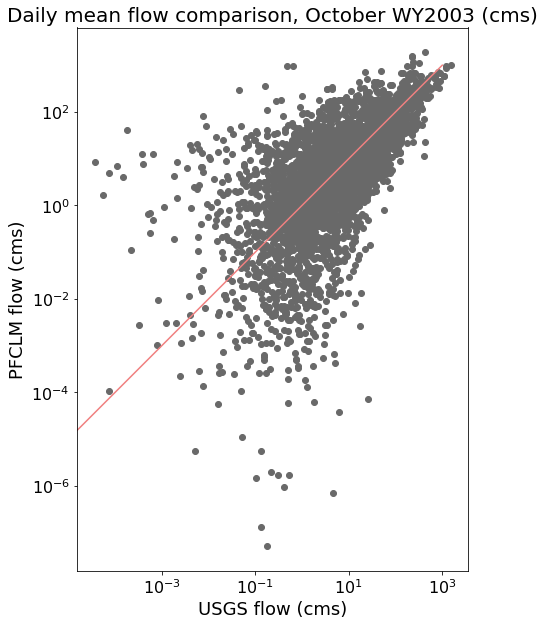

In [18]:
# Scatter plot of daily mean flow for October WY2003, PF vs. USGS
fig = plt.figure(figsize=(10,10), dpi=72)
ax = fig.add_subplot()

ax.scatter(usgs_daily_flow['daily mean'], CONUS2_daily_flow['daily mean'], color = 'dimgrey')
ax.plot(range(1000), color = 'lightcoral')
plt.ylabel('PFCLM flow (cms)',fontsize=18)
plt.xlabel('USGS flow (cms)',fontsize=18)
plt.title('Daily mean flow comparison, October WY2003 (cms)',fontsize=20)
ax.set_xscale('log')
ax.set_yscale('log')
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
# square plot
ax.set_aspect('equal', adjustable='box')
plt.savefig(f'{plot_dir}/Oct_WY2003_daily_mean_flow_comparison_scatter_LOG.png')




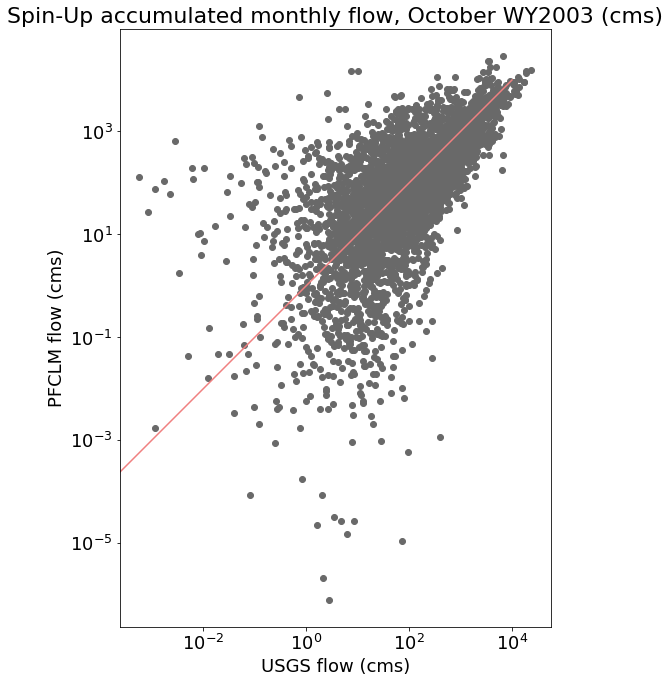

In [20]:
# Scatter plot of monthly total flow for October WY2003, PF vs. USGS
fig = plt.figure(figsize=(11,11), dpi=72)
ax = fig.add_subplot()

ax.scatter(usgs_daily_flow['usgs total flow'], CONUS2_daily_flow['pf total flow'], color = 'dimgrey')
# square plot
ax.set_aspect('equal', adjustable='box')
ax.plot(range(10000), color = 'lightcoral')
plt.ylabel('PFCLM flow (cms)',fontsize=18)
plt.xlabel('USGS flow (cms)',fontsize=18)
plt.title('Spin-Up accumulated monthly flow, October WY2003 (cms)',fontsize=22)
#ax.set_xscale('symlog')
#ax.set_yscale('symlog')
ax.set_xscale('log')
ax.set_yscale('log')
ax.xaxis.set_tick_params(labelsize=18)
ax.yaxis.set_tick_params(labelsize=18)

plt.savefig(f'{plot_dir}/Oct_WY2003_total_monthly_flow_log_comparison_scatter.png')

In [ ]:
CONUS2_daily_flow['monthly total (log)'].min()

In [ ]:
usgs_daily_flow['monthly total (log)'].min()

In [ ]:
#df["A"].str[:-1]

metadata_df['HUC2'] = metadata_df['huc'].astype(str).str[:-6]
metadata_df['HUC2']

In [ ]:
# Scatter plot of daily mean flow for October WY2003, PF vs. USGS

plot_df = pd.DataFrame().assign(CONUS_mean = CONUS2_daily_flow['daily mean'],USGS_mean = usgs_daily_flow['daily mean'], HUC2 = metadata_df['HUC2'])
groups = plot_df.groupby('HUC2')
groups


In [ ]:

for name, group in groups:
    fig = plt.figure(figsize=(5,5), dpi=72)
    ax = fig.add_subplot()
    ax.plot(group.USGS_mean,group.CONUS_mean, marker='o', linestyle='', label=name)
    ax.set_aspect('equal', adjustable='box')
    ax.legend()
    ax.plot(range(50), color = 'lightcoral')
    plt.ylabel('PFCLM flow (cms)',fontsize=18)
    plt.xlabel('USGS flow (cms)',fontsize=18)
    plt.title(f'Daily mean flow, OctWY2003 for HUC2 (cms)',fontsize=20)
    
    

# ax.scatter(CONUS2_daily_flow['daily mean'],usgs_daily_flow['daily mean'], c = metadata_df['HUC2'], cmap = 'greens')
# ax.plot(range(1000), color = 'lightcoral')
# plt.xlabel('PFCLM flow (cms)',fontsize=18)
# plt.ylabel('USGS flow (cms)',fontsize=18)
# plt.title('Daily mean flow comparison, October WY2003 (cms)',fontsize=20)
# ax.xaxis.set_tick_params(labelsize=16)
# ax.yaxis.set_tick_params(labelsize=16)
# # square plot
# ax.set_aspect('equal', adjustable='box')
# #plt.savefig(f'{plot_dir}/Oct_WY2003_daily_mean_flow_comparison_scatter.png')

In [ ]:
huc_2_names = {1:'New England', 2:'Mid-Atlantic', 3:'South Atlantic-Gulf', 4:'Great Lakes',
              5:'Ohio', 6:'Tennessee', 7:'Upper Miss', 8:'Lower Miss', 9:'Souris-Red-Rainy',
              10: 'Missouri', 11: 'Ar-White-Red', 12: 'Texas', 13: 'Rio Grande', 
              14: 'Upper CO', 15: 'Lower CO', 16: 'Great Basin', 17: 'Pacific Northwest',
              18: 'California'}

In [ ]:
fig = plt.figure(figsize=(2,2), dpi=300)
ax = fig.add_subplot()

In [ ]:
plt.scatter(CONUS2_daily_flow['daily mean log'],usgs_daily_flow['daily mean log'])
plt.xlabel('pf flow')
plt.ylabel('usgs flow')